# <u>Rate My Professors Sentiment Analysis</u>

![alt text](https://www.umass.edu/admissions/sites/default/files/RateMyProfessor.jpg)

## What is the Rate My Professors?

Rate my professors, a well-known and popular website among post-secondary students, allows one to post anonymous reviews of both their school and professors. I must confess that I have used it on ocassion, both to post reviews on my professors and also using the ratings to avoid classes with unpopular professors. It is quite helpful! It only occured to me recently however, that it contains a treasure trove of comments which already have a rating assigned to them. A supervised training set was just waiting to be scraped!  

In this project, I manually scraped the data solely containing to school-related comments and ratings using Scrapy and Selenium. While I did create a script to scrape professor ratings and comments, it would have taken much much longer time to scrape and ultimatley for the purpose of this project, was not necessary. I was able to scrape all school-related comments and ratings, totalling 300,000 data points.

I next tried to uncover some general trends in the data, while also connecting school ratings with school rankings, tuition and other such information using scraped data from a separate reliable source.

After processing and cleaning it, I then built a number of models including feature-based, word embedding based and transformer based models (with hyperparameter tuning).

Finally, I created a Python Web application using Flask (deployed through Heroku) which contains many of the built models and which predicts the sentiment for a comment entered by the user.

Please feel free to drop me a line with any suggestions, ideas or if you have any questions. Thanks!

*https://www.ratemyprofessors.com/*<br>
*https://ratemyprof-sentiment.herokuapp.com/*

***DISCLAIMER: I would recommend that you run this notebook on Google Collab given that you can use use a GPU Accelerator on some of the deep learning models and you can also run shell commands which is needed to run the fasttext library. Thanks!***

## Obtaining the Data

*Sample Rating*:

![alt text](https://github.com/ujjawalmadan/Rate-My-Professors/blob/master/sample%20school1.png?raw=true)

For this project, the only way to acquire the data was by scraping it directly from the web as there is no publicly available dataset. Part of the challenge fun of this project was the fact that there was nothing publicly available and that I had to scrape it myself, making it more difficult but ultimately much more satisfying.

To do this, I created a script in both Splash and Selenium, ultimately only scraping it through Selenium. In total, it took a total of approximately 20 hours using Selenium. Fortuitiously, I found that each individual school page had a unique ID number and by simplying iterating over id numbers ranging from 0 to 20,000 I was able to obtain all the information. Pagination on the other hand would certainly make the task slightly more complicated as well as less efficient computationally.

While both Splash and Selenium have their pros and cons, I used Selenium rather than Splash as it was much much faster and because the total number of requests were relatively small. By rotating the IP Addresses using a VPN, enabling autothrottle, setting download delays and keeping the number of requests relatively small on each IP address, I was able to stay under the radar which is often much harder with Selenium. Although Splash allows the user to set a custom user agent (which makes one harder to detect) and one can even utilize a user-agent randomizer making it even harder to be detected, I found that some of the page requests timed out and I ocassionally received other errors which made Splash quite inconsistent. Regardless, I have attached both scripts so feel free to use whichever one you prefer.

Just a quick tip if using Splash with Docker, enter this into the Docker Quickstart terminal "docker run -it -p 8050:8050 --memory=4.5G --restart=always scrapinghub/splash --maxrss 4000" to prevent Docker from automatically stopping after a hundred or so requests.

## Preprocessing

As with any dataset, we need to preprocess the data for us to be able to use it. Of course, as this data has been obtained from scraping it directly from the web, it's even more important than we are on the look out for any anomalies and filter out any outliers.

####  Importing Packages

In [ ]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sn
from plotnine import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import pickle

In [ ]:
df_fiveclass = pd.read_csv("https://raw.githubusercontent.com/ujjawalmadan/Rate-My-Professors/master/df_fiveclass.csv")

#### Importing data and inital pre-processing

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
### Read in csv

df_original = pd.read_json('https://raw.githubusercontent.com/ujjawalmadan/Rate-My-Professors-Sentiment-Analysis/master/Rate%20My%20Professors%20Data.json')
#For some reason, the ID code returned by the scraping was always behind by two. Rest assured, I made sure that all records were obtained.
df_original['Code'] += 2

In [ ]:
### Basic Processing

df_original = df_original.drop_duplicates(subset=['School Name', 'Location', 'Overall Quality Rating'])
df_original['University Location'] = df_original['Location']
del df_original['Location']

In [ ]:
### Modifying dataframe so that each row contains just one comment

l = []
out = []
for n, row in df_original.iterrows():
    for k in range(len(row['Score Name'])):
        row['Uni: ' + row['Score Name'][k].capitalize()] = row['Scores'][k]
    for i in range(len(row['Comments'])):
        row['Comment'] = row['Comments'][i]
        row['Comment Score'] = row['Comment Scores'][i]
        row['Comment Score Name'] = row['Comment Score Names'][i]
        l.append(dict(zip(row['Comment Score Name'], row['Comment Score'])))
        out += [row.copy()]

In [ ]:
### The Detailed Comment Ratings were not being correctly flattened in the Dataframe so I created a separate table. We will now merge the two together.

df = pd.DataFrame(out)
d = pd.DataFrame(l)
df = pd.concat([df.reset_index(drop=True), d.reset_index(drop=True)], axis=1)
del d

In [ ]:
### Some more processing by removing rows, changing data types of ratings into float, and averaging the comment ratings

df['Comment Score'] = df['Comment Score'].apply(lambda x: [i.replace(',', '') for i in x])
df['Comment Score'] = df['Comment Score'].apply(lambda x: np.array(x, dtype=np.float32))
df['Average Comment Score'] = df['Comment Score'].apply(lambda x: np.round(np.mean(x), 3))

#### Checking for Outliers

In [ ]:
df[(df['Average Comment Score'] > 5) | (df['Average Comment Score'] < 0)]

Code                    School Name  ...  Campus Average Comment Score
317228  15339  Universal Technical Institute  ...     NaN               115.556

[1 rows x 35 columns]

In [ ]:
df[(df['Overall Quality Rating'] > 5) | (df['Overall Quality Rating'] < 0)]

Code                    School Name  ...  Campus Average Comment Score
317225  15339  Universal Technical Institute  ...     NaN                 1.000
317226  15339  Universal Technical Institute  ...     NaN                 1.000
317227  15339  Universal Technical Institute  ...     NaN                 1.333
317228  15339  Universal Technical Institute  ...     NaN               115.556
317229  15339  Universal Technical Institute  ...     NaN                 3.889

[5 rows x 35 columns]

It seems that there are some outliers (comments), with the University Technical Institute having a 24.6 Overall Quality Rating, having a University reputation of 202, and a certain rating relating to reputation made by an individual user that gave them 1000. Obviously, this is the type of outlier that does not belong in the dataset. Wanting to confirm that it was the website and not some issue with my crawler, I found the page and indeed saw that a rating of 1000 was given.

*https://www.ratemyprofessors.com/campusRatings.jsp?sid=15339*

![alt text](https://github.com/ujjawalmadan/Rate-My-Professors/blob/master/Annotation%202020-06-30%20173118.png?raw=true)

In [ ]:
### Removing Outliers

df = df[df['Code'] != 15339]

#### Final Processing

In [ ]:
### Three versions of our dataframe: df_short contains just average university and commment ratings. df_comment which contains detaioled comment metrics. df_full contains both detailed and university comment ratings.

df_short = df[['Code', 'School Name', 'University Location', 'Overall Quality Rating', 'Comment', 'Average Comment Score']]
l1 = df.columns.tolist()[9:19]
l2 = df.columns.tolist()[22:34]
df_comment = df[['Code', 'School Name', 'University Location', 'Overall Quality Rating', 'Comment', 'Average Comment Score'] + l2]
df_full = df[['Code', 'School Name', 'University Location', 'Overall Quality Rating', 'Comment', 'Average Comment Score'] + l1 + l2]

In [ ]:
df_original.head()

Code  ... University Location
0     1  ...         Abilene, TX
1     2  ...          Tifton, GA
2     3  ...   San Francisco, CA
3     4  ...      Bryn Athyn, PA
4     5  ...         Alamosa, CO

[5 rows x 9 columns]

In [ ]:
df_short.head()

Code  ... Average Comment Score
0     1  ...                   2.8
1     1  ...                   3.7
2     1  ...                   4.1
3     1  ...                   4.2
4     1  ...                   4.2

[5 rows x 6 columns]

In [ ]:
df_comment.head()

Code                   School Name University Location  ...  Safety Library  Campus
0     1  Abilene Christian University         Abilene, TX  ...       3     NaN     NaN
1     1  Abilene Christian University         Abilene, TX  ...       4     NaN     NaN
2     1  Abilene Christian University         Abilene, TX  ...       3     NaN     NaN
3     1  Abilene Christian University         Abilene, TX  ...       5     NaN     NaN
4     1  Abilene Christian University         Abilene, TX  ...       5     NaN     NaN

[5 rows x 18 columns]

In [ ]:
df_full.head()

Code                   School Name University Location  ...  Safety Library  Campus
0     1  Abilene Christian University         Abilene, TX  ...       3     NaN     NaN
1     1  Abilene Christian University         Abilene, TX  ...       4     NaN     NaN
2     1  Abilene Christian University         Abilene, TX  ...       3     NaN     NaN
3     1  Abilene Christian University         Abilene, TX  ...       5     NaN     NaN
4     1  Abilene Christian University         Abilene, TX  ...       5     NaN     NaN

[5 rows x 28 columns]

#### NA or empty comments?

In [ ]:
### Filtering out invalid comments: comments that contain Not specified, None, na etc. These are individuals who entered numerical ratings but did not enter any text comment.

df_short.groupby('Comment').count().sort_values('School Name', ascending = False).head(10)

Code  ...  Average Comment Score
Comment                ...                       
Not Specified.  31849  ...                  31849
None.           22460  ...                  22460
Great school      454  ...                    454
Great school!     345  ...                    345
.                 343  ...                    343
good              278  ...                    278
great school      253  ...                    253
none              227  ...                    227
None              205  ...                    205
Love it           201  ...                    201

[10 rows x 5 columns]

In [ ]:
invalid_comments = df_short[df_short['Comment'].isin(['Not Specified', 'Not Specified.', 'None', 'None.', 'none', 'N/A', 'no', 'NA', 'n/a', '.', 'na', 'na.', 'No Comment', '...']) == True]

In [ ]:
### Comparing Average Comment Ratings by the Invalid Comment Ratings:

print('Mean of Average Comment Ratings: ' + str(round(df['Average Comment Score'].mean(), 2)))
print('Median of Average Commment Ratings: ' + str(round(df['Average Comment Score'].median(), 2)))
print('Standard Deviation of Average Comment Ratings: ' + str(round(df['Average Comment Score'].std(), 2)))
invalid_comments.groupby('Comment').agg(['count', 'mean', 'median', 'std'])['Average Comment Score'].sort_values('count', ascending = False)

Mean of Average Comment Ratings: 3.66
Median of Average Commment Ratings: 3.8
Standard Deviation of Average Comment Ratings: 0.94


count      mean  median       std
Comment                                          
Not Specified.  31849  3.816225   4.000  0.925530
None.           22460  3.825368   4.000  0.930459
.                 343  3.607880   3.700  0.879372
none              227  3.473379   3.700  1.148435
None              205  3.556093   3.700  0.968790
N/A               126  3.775310   3.900  0.817774
n/a                90  3.848778   4.000  0.856379
...                77  3.331325   3.400  0.935348
NA                 77  3.550208   3.556  0.723613
no                 74  3.265905   3.300  0.942894
na                 50  3.755980   3.900  0.853344
No Comment         24  3.140292   3.111  1.000614
Not Specified       2  2.650000   2.650  2.333453
na.                 1  3.700000   3.700       NaN

Interestingly, we find that while the mean comment rating is 3.74, those who chose not to enter anything (None. and Not Specified.) had a surprisingly higher rating on average and the median of those ratings was also on the higher side. This may lightly suggest that those who have higher ratings perhaps do not feel the need to share their comments, and those dissatisfied want to write down their critiques on the school. Intuitively, this makes sense.

However, those that deliberately entered 'None' or 'NA' etc. have varying ratings which veer on the lower side.

In [ ]:
import numpy as np

In [ ]:
np.mean(df_short[df_short['School Name'] == 'Truman State University']['Average Comment Score'])

3.619920326894023

In [ ]:
np.mean(df_short['Average Comment Score'])

3.664610498606723

## Analysis

### Initial Analysis and Visualization

Let's start by doing a basic analysis of our data

#### WordCloud

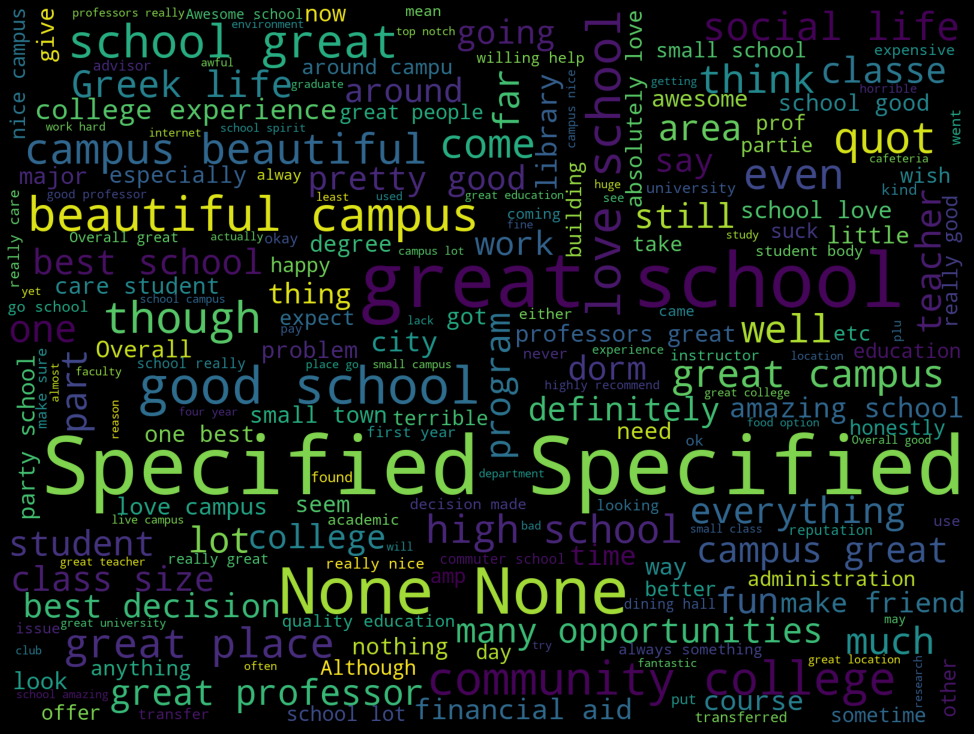

In [ ]:
sentences = ' '.join(list(df_short['Comment'][0:250000]))
wordcloud = WordCloud(width=1600, height=1200, background_color="black").generate(sentences)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#### Distribution of the Average Comment Ratings

Text(0, 0.5, 'Number of Comments')

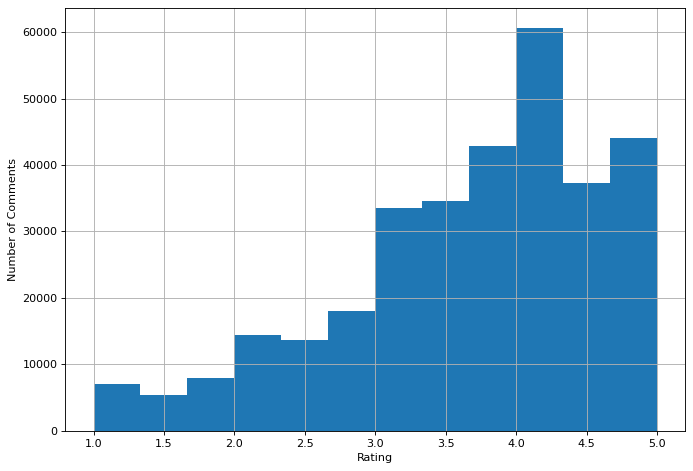

In [ ]:
### Taking a look at the distribution of the Average Comment Ratings

fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')
df['Average Comment Score'].hist(bins = 12)
plt.xlabel('Rating')
plt.ylabel('Number of Comments')

As we can easily observe, the ratings unsurprisingly are left skewed, with the median rating higher than the mean rating. The most common ratings seems to be between the intervals of 4 and 4.333.

#### Grouping by College/University Location

In [ ]:
### Processing

df['State'] = df['University Location'].apply(lambda x: x[-2:])
state = df.groupby('State').count().sort_values('Code', ascending = False)['Code']
state.head(10)
state.tail(10)
del df['State']

In [ ]:
Location_each_uni = df_original.groupby('University Location').count().sort_values('Code', ascending = False)['Code']
Location_each_uni.head(10)

University Location
New York, NY        101
Chicago, IL          76
Toronto, ON          54
Los Angeles, CA      54
London, LONDON       54
Vancouver, BC        52
Philadelphia, PA     43
San Diego, CA        42
Houston, TX          40
Atlanta, GA          39
Name: Code, dtype: int64

In [ ]:
Location_each_comment = df.groupby('University Location').count().sort_values('Code', ascending = False)['Code']
Location_each_comment.head(10)

University Location
New York, NY        4485
Toronto, ON         3115
Chicago, IL         2924
Boston, MA          2515
Los Angeles, CA     2213
Houston, TX         2157
San Antonio, TX     1998
Philadelphia, PA    1908
Ottawa, ON          1821
Brooklyn, NY        1739
Name: Code, dtype: int64

#### Number of Schools VS. Number of Comments Received

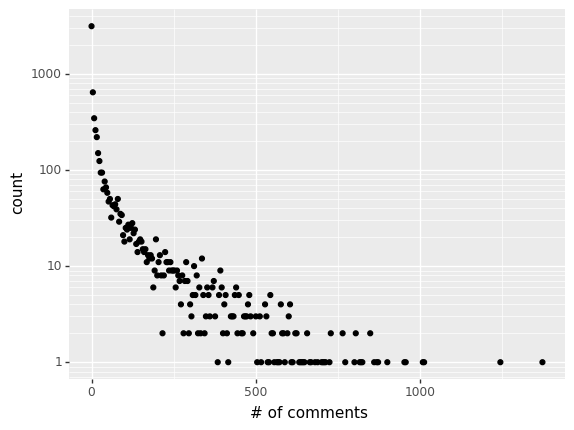

<ggplot: (-9223363252288733240)>

In [ ]:
df_original['# of comments'] = df_original['Comment Scores'].apply(lambda x: len(x)//4*4)
comments_number = df_original.groupby('# of comments').agg(['count', 'mean'])['Overall Quality Rating']
comments_number.reset_index(inplace=True)
ggplot(comments_number, aes('# of comments', 'mean')) + geom_point() + geom_smooth()
ggplot(comments_number, aes('# of comments', 'count')) + geom_point() + scale_y_continuous(trans='log10')

As we can see, there are a number of schools that receive very few comments with the number of universities drastically decreasing with number of comments.

### Comparing School Quality with School Rankings, Tuition etc.

While the purpose of this project is indeed to perform sentiment analysis on the comments, I still thought it would be interesting to see whether overall school rating would correlate at all with ranking of schools. Luckily I found a website (link attached underneath) that has ranked the top 1000 schools in the United States. Given that there was a very high probability for most of these schools to be on Rate My Professors, if not all, I thought it would be interesting to compare Quality of School with Ranking, as well as Tuition and Salary earned after 10 years. This was quite easily obtained by use of Splash again. The code for scraping is attached in the github repo.

*https://www.timeshighereducation.com/rankings/united-states/2020#!/page/0/length/-1/name/w/sort_by/rank/sort_order/asc/cols/stats*

In [ ]:
import string

In [ ]:
### Import and preprocessing

rankings = pd.read_csv('https://raw.githubusercontent.com/ujjawalmadan/Rate-My-Professors/master/School%20Rankings.csv')
rankings['School Name'] = rankings['Name']
del rankings['Name']

df_ranking = df_original.copy()
df_ranking = df_ranking[df_ranking['Overall Quality Rating'] != 0]

char = string.punctuation[:6] + string.punctuation[7:]
df_ranking['School Name'] = df_ranking['School Name'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).replace('.', '').lower())
rankings['School Name'] = rankings['School Name'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).replace('.', '').lower())

rankings_merged = pd.merge(rankings, df_ranking[['School Name', 'Code', 'Overall Quality Rating', 'University Location']], 'left', 'School Name')
missing_schools = rankings_merged[rankings_merged['Code'].isnull()]['School Name'].apply(lambda x: x.replace('-', ' '))

rankings_merged ['Ranking'] = [i for i in range(rankings_merged.shape[0])]
rankings_merged['Tuition'] = rankings_merged['Tuition'].apply(lambda x: float(str(x).replace(',', '').replace('$', '')))
rankings_merged['Board'] = rankings_merged['Board'].apply(lambda x: float(str(x).replace(',', '').replace('$', '')))
rankings_merged['Salary'] = rankings_merged['Salary'].apply(lambda x: float(str(x).replace(',', '').replace('$', '')))

NameError: ignored

Let's take a look and see how much of the ranking data got matched with the rate my profs data.

In [ ]:
print(str(100*(1 - (len(missing_schools)/rankings.shape[0])))[:2] + '% of data was matched!')

80% of data was matched!


Not bad! Since we are just using this to get an approximation and are not trying to make determinations on every school listed in the ranking data, this will suffice. Looking through the data that wasn't matched, it seems it would take regex for each school to manually link the rate my profs data to the ranking data.

In [ ]:
### Feel free to see what kind of schools did not cross match with rate my profs.

missing_schools.head(15)

25           university of california los angeles
27                university of michiganann arbor
33    university of north carolina at chapel hill
42                university of washingtonseattle
46               purdue university west lafayette
47      university of illinois at urbanachampaign
50           university of virginia main campus  
67                 university of wisconsinmadison
75            university of maryland college park
78             texas am universitycollege station
79                                  william  mary
86            ohio state university main campus  
92                     franklin  marshall college
96            university of minnesota twin cities
99      university of pittsburghpittsburgh campus
Name: School Name, dtype: object

#### Ranking VS School Rating

/usr/local/lib/python3.6/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 158 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


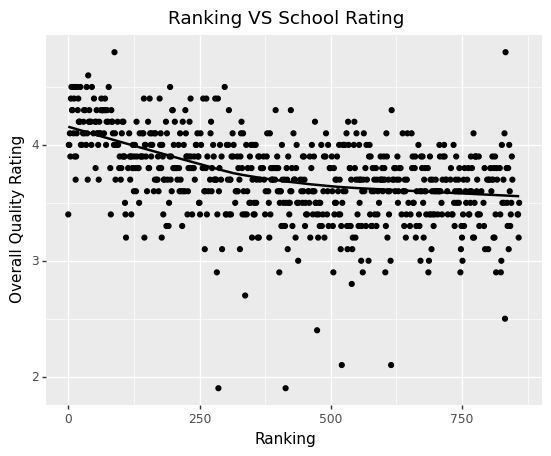

<ggplot: (-9223363252304258914)>

In [ ]:
#MATPLOTLIB Version
#rankings_merged[['Ranking', 'Overall Quality Rating']].plot(kind = 'scatter', x = 'Ranking', y = 'Overall Quality Rating')

ggplot(rankings_merged, aes(x='Ranking', y='Overall Quality Rating')) + geom_point() + geom_smooth() + ggtitle('Ranking VS School Rating')

It seems that there is indeed a correlation between Ranking and University Rating, albeit a small one. However, that doesn't seem to extend for schools that are ranked below 500.

Let's take a look at the outliers, the schools that are ranked both particularly high and particularly low.

In [ ]:
### Ranked high

rankings_merged[rankings_merged['Overall Quality Rating'] > 4.5]

Ranking  Tuition  ...  Overall Quality Rating  University Location
38        38  52825.0  ...                     4.6        Claremont, CA
88        88  50850.0  ...                     4.8       Pittsburgh, PA
833      833  27100.0  ...                     4.8       Washington, DC

[3 rows x 8 columns]

In [ ]:
### Ranked low

rankings_merged[rankings_merged['Overall Quality Rating'] < 2.5]

Ranking  Tuition  ...  Overall Quality Rating  University Location
286      286  35870.0  ...                     1.9        Vancouver, BC
414      414  31842.0  ...                     1.9           Ruskin, FL
474      474  35830.0  ...                     2.4        Charlotte, NC
521      521  36535.0  ...                     2.1       Wilmington, DE
615      615  29420.0  ...                     2.1           Peoria, IL

[5 rows x 8 columns]

Claremont McKennna sounds pretty great considering they are ranked relatively high and have been giving a great university rating as well.

#### Ranking VS Tuition

C:\Users\ujjaw\AppData\Roaming\Python\Python37\site-packages\plotnine\stats\smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\ujjaw\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:464: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


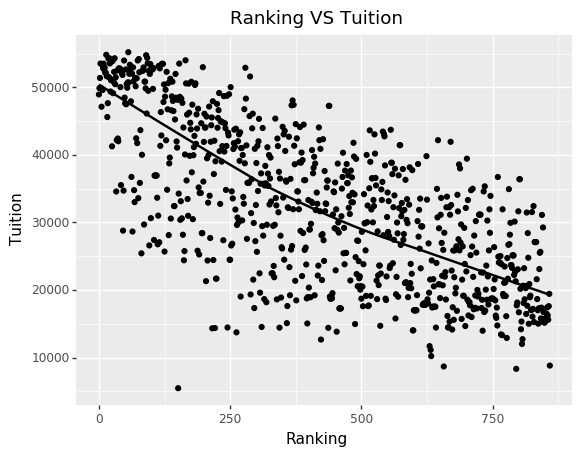

<ggplot: (-9223371899129618272)>

In [ ]:
# PLT VERSION
#rankings_merged[['Ranking', 'Tuition']].plot(kind = 'scatter', x = 'Ranking', y = 'Tuition')

# GGPLOT VERSION
ggplot(rankings_merged, aes(x='Ranking', y='Tuition')) + geom_point() + geom_smooth() + ggtitle('Ranking VS Tuition')

Here we can see a clear correlation between Ranking and Tuition. It seems that with higher ranked schools, the tuition is also relatively high. Whether that is because higher ranked schools can charge more, or because they charge more they provide more resources for students or there are external factors which are the cause of this, we cannot determine at this time. Let's take a look at that school which has a relatively high ranking but very low tuition. Looks Promising...

In [ ]:
rankings_merged[rankings_merged['Tuition'] < 9000]

Ranking  Tuition    Board   Salary                     School Name  \
151      151   5460.0   7530.0  57900.0  Brigham Young University-Provo   
657      657   8678.0   8162.0  39700.0        Bemidji State University   
795      795   8327.0  12250.0  40800.0       SUNY Alfred State College   
859      859   8811.0   9090.0  34500.0     Youngstown State University   

       Code  Overall Quality Rating University Location  
151     NaN                     NaN                 NaN  
657    98.0                     3.5         Bemidji, MN  
795     NaN                     NaN                 NaN  
859  1226.0                     3.5      Youngstown, OH

Looks like Brigham Young University is a great place to go. As some may be aware however, it is not secular university so it may not be for everyone. Sounds like a great school however for someone who is Mormon!

#### Ranking VS Salary

C:\Users\ujjaw\AppData\Roaming\Python\Python37\site-packages\plotnine\stats\smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\ujjaw\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:464: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


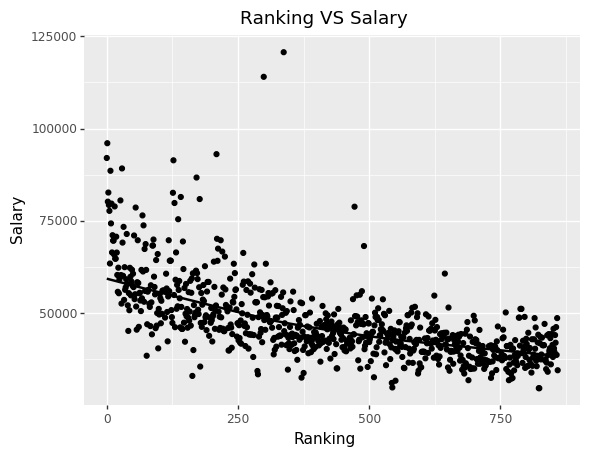

<ggplot: (-9223371899126834480)>

In [ ]:
# PLT VERSION
#rankings_merged[['Ranking', 'Salary']].plot(kind = 'scatter', x = 'Ranking', y = 'Salary')

# GGPLOT VERSION
ggplot(rankings_merged, aes(x='Ranking', y='Salary')) + geom_point() + geom_smooth() + ggtitle('Ranking VS Salary')

There also seems to be a correlation between school ranking and average salary after 10 years. Intuitively that makes a lot of sense! Which schools have their graduates on average making more than a 100,000?

In [ ]:
rankings_merged[rankings_merged['Salary'] > 100000]

Ranking  Tuition    Board    Salary  \
299      299  32590.0  16400.0  114033.0   
337      337  33621.0  10800.0  120700.0   

                                        School Name  Code  \
299                                MCPHS University   NaN   
337  Albany College of Pharmacy and Health Sciences  13.0   

     Overall Quality Rating University Location  
299                     NaN                 NaN  
337                     2.7          Albany, NY

It makes much more sense now why those schools have such a high salary, despite not having a very high ranking. Both schools as it turns out are for pharmacy students, hence the high salaries...

#### Tuition VS School Rating

C:\Users\ujjaw\AppData\Roaming\Python\Python37\site-packages\plotnine\stats\smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\ujjaw\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:464: PlotnineWarning: geom_point : Removed 159 rows containing missing values.


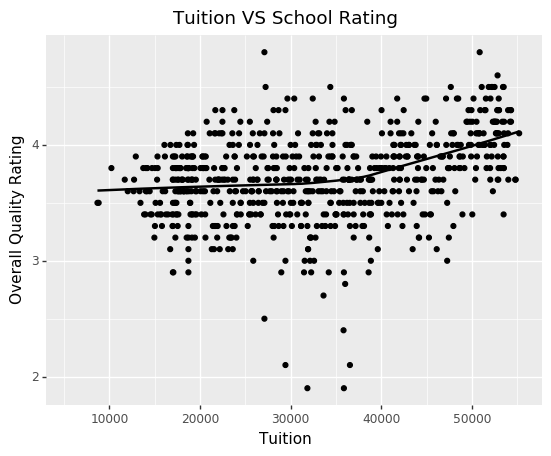

<ggplot: (-9223371899428540476)>

In [ ]:
# PLT VERSION
#rankings_merged[['Tuition', 'Overall Quality Rating']].plot(kind = 'scatter', x = 'Tuition', y = 'Overall Quality Rating')

# GGPLOT VERSION
ggplot(rankings_merged, aes(x='Tuition', y='Overall Quality Rating')) + geom_point() + geom_smooth()+ ggtitle('Tuition VS School Rating')

Unfortunately, it seems that tuition is also correlated with Quality of School. It would have been nice to see no relationship between the two but it seems there is one, albeit only one for schools with tuition exceeding $35,000.

#### Tuition VS Salary

C:\Users\ujjaw\AppData\Roaming\Python\Python37\site-packages\plotnine\stats\smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\ujjaw\AppData\Roaming\Python\Python37\site-packages\plotnine\layer.py:464: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


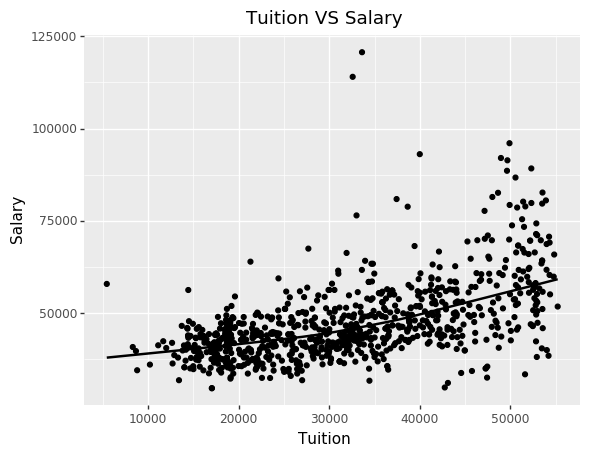

<ggplot: (-9223371899129419700)>

In [ ]:
# PLT VERSION
#rankings_merged[['Tuition', 'Salary']].plot(kind = 'scatter', x = 'Tuition', y = 'Salary')

# GGPLOT VERSION
ggplot(rankings_merged, aes(x='Tuition', y='Salary')) + geom_point() + geom_smooth() + ggtitle('Tuition VS Salary')

There is, unsurprisingly given all the analysis we have done so far, a relationship between tuition and salary. As tuition rises, it seems that the average salary of graduates will also tend to be higher. The two outliers as we already know are the two pharmacy related schools. I am curious to know which schools are towards the bottom right of the plot (expensive and low aveage salary).

In [ ]:
rankings_merged[(rankings_merged['Tuition'] > 40000) & (rankings_merged['Salary'] < 40000)]

Ranking  Tuition  ...  Overall Quality Rating      University Location
76        76  54200.0  ...                     4.2             Portland, OR
165      165  54010.0  ...                     3.7           Bronxville, NY
178      178  47446.0  ...                     3.2             Valencia, CA
232      232  44958.0  ...                     3.8            Galesburg, IL
233      233  44958.0  ...                     4.4              Toronto, ON
279      279  52906.0  ...                     3.7  Annandale-on-Hudson, NY
287      287  45750.0  ...                     3.6             Richmond, IN
288      288  51608.0  ...                     3.8              Amherst, MA
371      371  47420.0  ...                     3.8              Chicago, IL
375      375  44560.0  ...                     3.4             Sarasota, FL
438      438  47266.0  ...                     3.0        San Francisco, CA
439      439  47266.0  ...                     3.5              Oakland, CA
543      543  43100.0  ...                     NaN                      NaN
544      544  42750.0  ...                     4.0               Boston, MA

[14 rows x 8 columns]

It seems that most of these schools are focused on that arts. These results do indeed make sense as graduates of arts schools do not tend to have very high salaries after graduation. Knowing a few people who have attended some of these schools, and having received admission into Bard College myself, it just further goes to show that context of these particular entries is quite important. One might thing that these schools are somehow getting away with high tuition, whereas students of these schools are likely well aware that salaries are not that high after graduation and are willing to pay such costs regardless.

## Building our Model

It's time to build our model! Let's get into it!

### Removing NA Values

As we have seen, there are a number of data points which have a rating, but no comment. They are mostly in the form of Not Specified or None. Although we could include these points in our model, it really wouldn't make much sense since in this situation, we are trying to filter out reviews that will hopefully provide constructive criticism to the school administrators. It makes sense then to remove these values, and if we want to indeed predict a rating with an NA value, we can come back to it if necessary.

In [ ]:
len(df_short[df_short['Comment'].isin(['Not Specified', 'Not Specified.', 'None', 'None.', 'none', 'N/A', 'no', 'NA', 'n/a', '.', 'na', 'na.', 'No Comment', '...']) == True])

55605

In [ ]:
df_short = df_short[df_short['Comment'].isin(['Not Specified', 'Not Specified.', 'None', 'None.', 'none', 'N/A', 'no', 'NA', 'n/a', '.', 'na', 'na.', 'No Comment', '...']) == False].reset_index()
df_short.head()

NameError: ignored

It is unfortunate that we had to remove around 50,000 rows that contain no ratings, but we are still left with a pretty sizeable number of entries (263,000)

### Class Imbalance

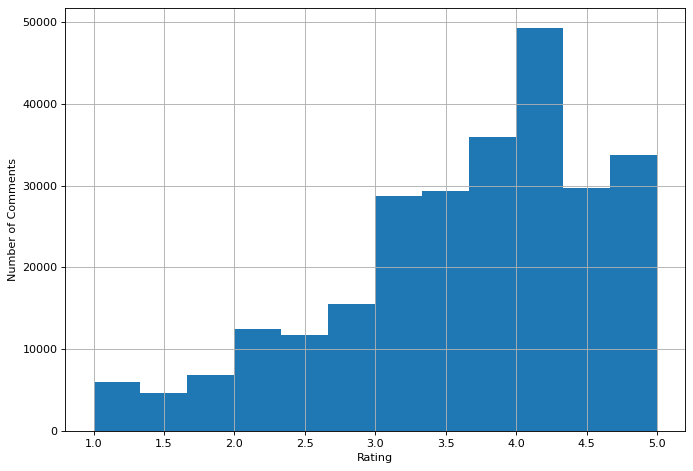

In [ ]:
#Distribution of the Data

def dist_plot(df, b = 12):
    fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')
    df.hist(bins = b)
    plt.xlabel('Rating')
    plt.ylabel('Number of Comments')

dist_plot(df_short['Average Comment Score'])

In [ ]:
#Percentage of data below 3

str(round((df_short['Average Comment Score'] < 3).mean()*100, 2)) + ' % of the data has a rating below 3'

'21.64 % of the data has a rating below 3'

The question of class imbalance is certainly worth discussing at this point as well. As we see again in the below distribution (same as the one above except with NAs' remove), the data is definitely not uniformly distributed. In fact, we can see that approximately 20 percent of the scores are below 3 (in between 1 and 5) and 80 percent above 3. If we were doing a binary classification between negative and positive comments, that would mean that the class ratio would be 80:20.

An imbalanced dataset can be corrected by weighting certain labels more in our model. I would much prefer however to simple filter our dataset so that it is more balanced. As we have more than enough comments and ratings, I think this option is the best way to go.


In [ ]:
def sampling_k_elements(group, k):
    if len(group) < k:
        return group
    return group.sample(k)

Before Balancing: 
4    102512
5     75591
3     44253
2     26715
1     14834
Name: Score, dtype: int64

Number of Rows: 78834
After Balancing: 
5    16000
4    16000
3    16000
2    16000
1    14834
Name: Score, dtype: int64


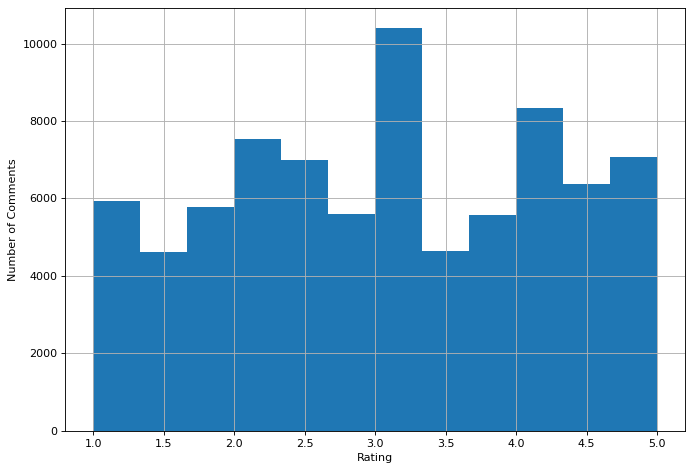

In [ ]:
# With Five classes

df_fiveclass = df_short.copy()
df_fiveclass['Score'] = df_fiveclass['Average Comment Score'].apply(lambda x : 4.9 if (x ==5) else x)
df_fiveclass['Score'] = (((df_fiveclass['Score']-1)//0.8)+1).astype('int32')
df_fiveclass.head()

print('Before Balancing: ')
print(df_fiveclass['Score'].value_counts())
print()

df_fiveclass = df_fiveclass.groupby('Score').apply(sampling_k_elements, 16000).reset_index(drop=True)
df_fiveclass = df_fiveclass.sample(frac=1).reset_index(drop=True)
print('Number of Rows: ' + str(df_fiveclass.shape[0]))

print('After Balancing: ')
print(df_fiveclass['Score'].value_counts())

dist_plot(df_fiveclass['Average Comment Score'], 12)

#### PREPROCESSING!

Preprocessing is a necessary step in any text analysis. A number of our models will have preprocessing built into them, so I will create a seperate cleaned version of our dataset. This way, we can also compare and contrast our model on both the raw and cleaned dataset if we like.

In [ ]:
df_fiveclass_clean = df_fiveclass.copy()

##### Spell Check

In [ ]:
# TextBlob Spell Check

from textblob import TextBlob

sample = TextBlob("I havv goood speling!")
print(sample.correct())

I have good spelling!


In [ ]:
str(TextBlob(df_fiveclass['Comment'][1]).correct())

'pretty awesome'

In [ ]:
df_fiveclass_clean['Comment'] = df_fiveclass['Comment'].apply(lambda x: str(TextBlob(x).correct()))

0     not the worst, not the best. Super cool music ...
1                                        pretty awesome
2     It's your basic computer school, wife, basic f...
3     They keep sending these stupid mails about att...
4     There are better and cooper universities elsew...
                            ...                        
95    The employees are so difficult to communicate ...
96    Must like any other community college honestly...
97                        Not too bad and not too good.
98    don't transfer into this school.  stay put or ...
99    Marking at Gateway is HORRIBLE. Take sure you'...
Name: Comment, Length: 100, dtype: object

##### More Preprocessing...

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Preprocessing

import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()
def preprocess_text(document):
  # Remove all the special characters
  document = re.sub(r'\W', ' ', str(document))

  # remove all single characters
  document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

  # Remove single characters from the start
  document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

  # Substituting multiple spaces with single space
  document = re.sub(r'\s+', ' ', document, flags=re.I)

  # Removing prefixed 'b'
  document = re.sub(r'^b\s+', '', document)

  # Converting to Lowercase
  document = document.lower()

  # Lemmatization
  tokens = document.split()
  tokens = [stemmer.lemmatize(word) for word in tokens]
  tokens = [word for word in tokens if word not in en_stop]
  tokens = [word for word in tokens if len(word) > 3]
  preprocessed_text = ' '.join(tokens)

  return preprocessed_text


In [ ]:
df_fiveclass_clean['Comment'] =  df_fiveclass_clean['Comment'].apply(preprocess_text)

### Helper Functions

Both of these helper functions will evaluate our model results. The first gives us the accuracy and F1 Score and the second gives us a confusion matrix

In [ ]:
# Evaluate Accuracy and F-1 Score
def multiclass_eval(predicted, target):
    print(confusion_matrix(target, predicted))
    print('Accuracy:' + str(accuracy_score(target, predicted)))
    print('F1 Score:' + str(metrics.f1_score(target, predicted, average='macro')))
    print()

# Confusion Matrix for Multiclass Classification
def cm_plot(predicted, target, size):
    df_cm = pd.DataFrame(confusion_matrix(target, predicted), range(1,size), range(1,size))
    plt.figure(figsize=(7,5))
    sn.set(font_scale=1.1) # for label size
    ax= plt.subplot()
    sn.heatmap(df_cm, annot=True, ax = ax, cmap='Blues', fmt='g'); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(range(1,6)); ax.yaxis.set_ticklabels(range(1,6));
    plt.show()

### Package Based Models

One of the obvious advantages of package-based tools like Vader and Textblob is that there is no training required per se. If we don't have any training data at all, we can still use a package like this to predict the sentiment. Both of these packages also very lightweight making it very to implement and deploy.

The disadvantages are that this is likely to not perform as well as some of the later models, even if we train it on our data. Let's see...

#### Model 1: Vader Model

Our first model is using built using VADER, a popular text classifier with a focus on social media texts.

*'VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the [MIT License] (we sincerely appreciate all attributions and readily accept most contributions, but please don’t hold us liable).'*

For more on vader, please check out this medium article.

*https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f*


In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()


     |████████████████████████████████| 133kB 3.0MB/s 


In [ ]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [ ]:
# Example

sentiment_analyzer_scores("Got a deadline to meet!!! No TGIF for me.")

Got a deadline to meet!!! No TGIF for me. {'neg': 0.35, 'neu': 0.65, 'pos': 0.0, 'compound': -0.6498}


In [ ]:
# Example on a sample comment

sentiment_analyzer_scores(df_fiveclass['Comment'][0])

not the worst, not the best. Super cool music scene. Decent bars. {'neg': 0.324, 'neu': 0.398, 'pos': 0.278, 'compound': -0.2311}


As we can see, VADER returns four values. Negative, Neutral, Positive and Compound. The Compound score returns the sum of all the lexicon ratings which have been normalized between -1 and +1. Let's train Vader now on our training set using all four values. VADER works just as well, if not better, raw text so we it won't be necessary for us to run it on our clean data.

In [ ]:
# Our VADER class which takes in any data, separates it into training and testing and evaluates it.

class vader():
    def __init__(self, data):
        self.results = []
        self.data = data

    def sentiment_analyzer_scores(self, sentence):
        return analyser.polarity_scores(sentence)

    def train(self):

        for text in self.data['Comment']:
            self.results.append(self.sentiment_analyzer_scores(text))

        self.detailed_results = pd.DataFrame(
    {'Positive': [i['pos'] for i in self.results],
     'Neutral': [i['neu'] for i in self.results],
     'Negative': [i ['neg'] for i in self.results],
     'Compound': [i ['compound'] for i in self.results],
     'Score': self.data['Score']})

    def linear_regression(self):
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LinearRegression

        X_train, X_test, y_train, y_test = train_test_split(self.detailed_results[['Positive', 'Neutral', 'Negative', 'Compound']]
                                            , self.detailed_results[['Score']], test_size=0.2, random_state=0)

        regressor = LinearRegression()
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        self.final = pd.DataFrame({'Prediction': list(np.round(y_pred.flatten(), 4)),
             'Actual': list(round(y_test['Score'], 1))})
        self.evaluate()

    def logistic_regression(self):
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LogisticRegression

        X_train, X_test, y_train, y_test = train_test_split(self.detailed_results[['Positive', 'Neutral', 'Negative', 'Compound']]
                                            , self.detailed_results[['Score']], test_size=0.2, random_state=0)

        regressor = LogisticRegression(multi_class='auto')
        regressor.fit(X_train, y_train)
        print(X_test.head(1))
        y_pred = regressor.predict(X_test)
        self.final = pd.DataFrame({'Prediction': list(np.round(y_pred.flatten(), 4)),
             'Actual': list(round(y_test['Score'], 1))})
        self.evaluate()

    def knn(self):
        from sklearn.model_selection import train_test_split
        from sklearn.neighbors import KNeighborsClassifier

        X_train, X_test, y_train, y_test = train_test_split(self.detailed_results[['Positive', 'Neutral', 'Negative', 'Compound']]
                                            , self.detailed_results[['Score']], test_size=0.2, random_state=0)

        regressor = KNeighborsClassifier()
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        self.final = pd.DataFrame({'Prediction': list(np.round(y_pred.flatten(), 4)),
             'Actual': list(round(y_test['Score'], 1))})
        self.evaluate()

    def svm(self):

        from sklearn.model_selection import train_test_split
        from sklearn.pipeline import Pipeline
        from sklearn.model_selection import GridSearchCV
        from sklearn.svm import SVC

        X_train, X_test, y_train, y_test = train_test_split(self.detailed_results[['Positive', 'Neutral', 'Negative', 'Compound']]
                                            , self.detailed_results[['Score']], test_size=0.2, random_state=0)
        parameters = {
            'clf__C': (0.1, 1, 10)
            }

        pipeline = Pipeline(
            [
            ('clf', SVC())
            ])

        gs_clf = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

        regressor = gs_clf.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        self.final = pd.DataFrame({'Prediction': list(np.round(y_pred.flatten(), 4)),
             'Actual': list(round(y_test['Score'], 1))})

        for param_name in sorted(parameters.keys()):
            print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

        self.evaluate()

    def evaluate(self):
        self.final['Actual'] = self.final['Actual'].astype(int)
        self.final['Prediction'] = self.final['Prediction'].apply(lambda x: round(x)).astype(int)
        self.final['Prediction'] = self.final['Prediction'].apply(lambda x : 1 if (x==0) else x)

        multiclass_eval(self.final['Prediction'], self.final['Actual'])
        cm_plot(self.final['Prediction'], self.final['Actual'], 6)

In [ ]:
model1 = vader(df_fiveclass)
model1.train()

[[ 367 1573  799  131    5]
 [ 161 1463 1255  363    8]
 [  56  842 1314 1010   38]
 [  16  343  879 1873  106]
 [   5  239  602 2095  224]]
Accuracy:0.3324031204414283
F1 Score:0.2943940737406363



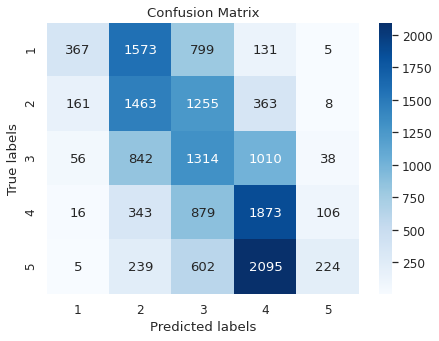

In [ ]:
model1.linear_regression()

      Positive  Neutral  Negative  Compound
6087     0.121    0.777     0.102      0.34
[[1531  641  420  188   95]
 [1191  718  650  475  216]
 [ 569  567  598  891  635]
 [ 168  297  389  926 1437]
 [  57  235  226  736 1911]]
Accuracy:0.3604997780173781
F1 Score:0.3493494619784942



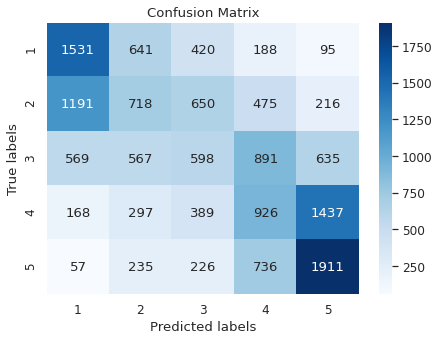

In [ ]:
model1.logistic_regression()

[[1336 1026  301  155   57]
 [1150 1187  504  278  131]
 [ 713  934  686  590  337]
 [ 309  546  604  903  855]
 [ 158  388  504  886 1229]]
Accuracy:0.3387454810680535
F1 Score:0.33835075543772086



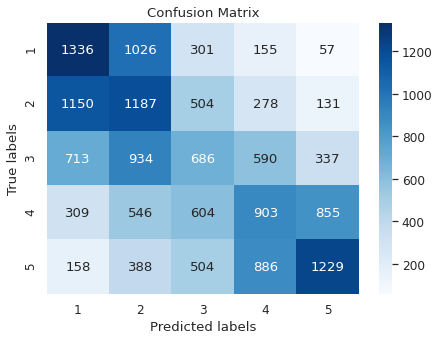

In [ ]:
model1.knn()

As SVM is very computationally expensive, running it on all the data is not feasible. However, even a smaller set should suffice as we are working with very few dimensions.

In [ ]:
model1a = vader(df_fiveclass[0:20000])
model1a.train()

clf__C: 10
[[357 219 110  34  12]
 [237 268 178  77  35]
 [103 206 193 162 141]
 [ 35 105 132 214 329]
 [ 10  91  92 176 484]]
Accuracy:0.379
F1 Score:0.37400199753513846



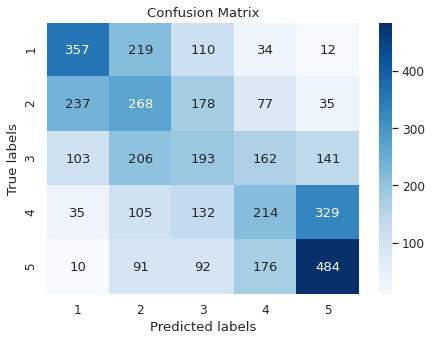

In [ ]:
model1a.svm()

As we can see, the best performing classifier on VADER was SVM. Hopefully we can greatly improve on this in the upcoming models.

Let's train our SVM Model on all the training data and export it for deployment.

In [ ]:
class vader_deploy():
    def __init__(self, data):
        self.results = []
        self.data = data

    def sentiment_analyzer_scores(self, sentence):
        return analyser.polarity_scores(sentence)

    def train(self):

        for text in self.data['Comment']:
            self.results.append(self.sentiment_analyzer_scores(text))

        self.detailed_results = pd.DataFrame(
    {'Positive': [i['pos'] for i in self.results],
     'Negative': [i ['neg'] for i in self.results],
     'Compound': [i ['compound'] for i in self.results],
     'Score': self.data['Score']})

    def logistic_regression(self):
        from sklearn.linear_model import LogisticRegression

        regressor = LogisticRegression(multi_class='auto')
        regressor.fit(self.detailed_results[['Positive', 'Negative', 'Compound']], self.detailed_results[['Score']])
        return regressor

model1 = vader_deploy(df_fiveclass)
model1.train()
vader_model = model1.logistic_regression()

import pickle
pickle.dump(vader_model, open('VADER.pkl','wb'))

#### Model 2: TextBlob

TextBlob is another tool that we can utilize in Python.

*TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.*

It uses a sentiment lexicon where each word has a predefined score and the average of all those scores is returned. The score we are interested in is the polarity score, given between -1 (negative) and +1 (positive).

This is again very lightweight and easy to use.

In [ ]:
#pip install -U textblob
from textblob import TextBlob

In [ ]:
# Example Good Sentence

good_sentence = df_short['Comment'][6]
print(good_sentence)
print(TextBlob(good_sentence).polarity)

I love how they always put God first
0.375


In [ ]:
# Example Bad Sentence

bad_sentence = df_short['Comment'][87]
print(bad_sentence)
print(TextBlob(bad_sentence).polarity)

This School is really bad
-0.6999999999999998


In [ ]:
# Our textblob class which takes in any data, separates it into training and testing and evaluates it.

class textblob():
    def __init__(self, data):
        self.results = []
        self.data = data

    def sentiment_analyzer_scores(self, sentence):
        return TextBlob(sentence).polarity

    def train(self):

        for text in self.data['Comment']:
            self.results.append(self.sentiment_analyzer_scores(text))

        self.results = pd.DataFrame(
    {'Predicted': self.results,
     'Score': self.data['Score']})

    def linear_regression(self):
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LinearRegression

        X_train, X_test, y_train, y_test = train_test_split(self.results[['Predicted']],
                                            self.results[['Score']],
                                            test_size=0.2, random_state=0)

        regressor = LinearRegression()
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        self.final = pd.DataFrame({'Prediction': list(np.round(y_pred.flatten(), 4)),
             'Actual': list(round(y_test['Score'], 1))})
        self.evaluate()

    def logistic_regression(self):
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LogisticRegression

        X_train, X_test, y_train, y_test = train_test_split(self.results[['Predicted']],
                                            self.results[['Score']],
                                            test_size=0.2, random_state=0)

        regressor = LogisticRegression(multi_class='auto')
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        self.final = pd.DataFrame({'Prediction': list(np.round(y_pred.flatten(), 4)),
             'Actual': list(round(y_test['Score'], 1))})
        self.evaluate()

    def knn(self):
        from sklearn.model_selection import train_test_split
        from sklearn.neighbors import KNeighborsClassifier

        X_train, X_test, y_train, y_test = train_test_split(self.results[['Predicted']],
                                            self.results[['Score']],
                                            test_size=0.2, random_state=0)

        regressor = KNeighborsClassifier()
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        self.final = pd.DataFrame({'Prediction': list(np.round(y_pred.flatten(), 4)),
             'Actual': list(round(y_test['Score'], 1))})
        self.evaluate()

    def svm(self):
        from sklearn.model_selection import train_test_split
        from sklearn.svm import SVC

        X_train, X_test, y_train, y_test = train_test_split(self.results[['Predicted']],
                                            self.results[['Score']],
                                            test_size=0.2, random_state=0)

        regressor = SVC()
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        self.final = pd.DataFrame({'Prediction': list(np.round(y_pred.flatten(), 4)),
             'Actual': list(round(y_test['Score'], 1))})
        self.evaluate()

    def evaluate(self):
        self.final['Actual'] = self.final['Actual'].astype(int)
        self.final['Prediction'] = self.final['Prediction'].apply(lambda x: round(x)).astype(int)
        self.final['Prediction'] = self.final['Prediction'].apply(lambda x : 1 if (x==0) else x)

        multiclass_eval(self.final['Prediction'], self.final['Actual'])
        cm_plot(self.final['Prediction'], self.final['Actual'], 6)


In [ ]:
model2 = textblob(df_fiveclass)
model2.train()

[[ 265 1049 1433  113   15]
 [ 121  838 2021  260   10]
 [  46  438 2224  514   38]
 [  13  113 1858 1111  122]
 [   6   47 1299 1433  380]]
Accuracy:0.30557493499080357
F1 Score:0.27146713627397806



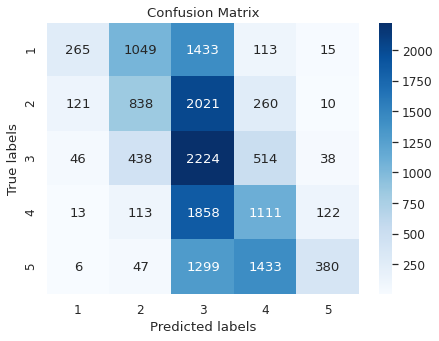

In [ ]:
model2.linear_regression()

[[1241  980  375  147  132]
 [ 881 1109  679  307  274]
 [ 441  879  806  557  577]
 [ 108  513  578  752 1266]
 [  49  344  372  564 1836]]
Accuracy:0.3643051943933532
F1 Score:0.3600887997094171



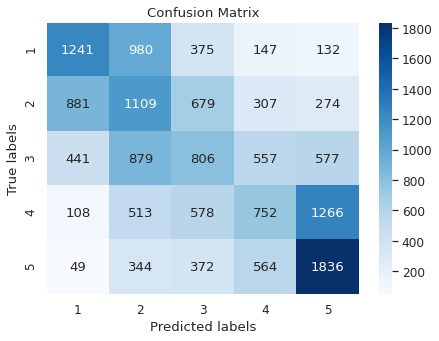

In [ ]:
model2.logistic_regression()

C:\Users\ujjaw\anaconda3\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[[1588  721  358  168   91]
 [1327  857  492  305  156]
 [ 920  788  643  560  334]
 [ 537  594  626  738  722]
 [ 424  479  439  712 1188]]
Accuracy:0.31800596181898905


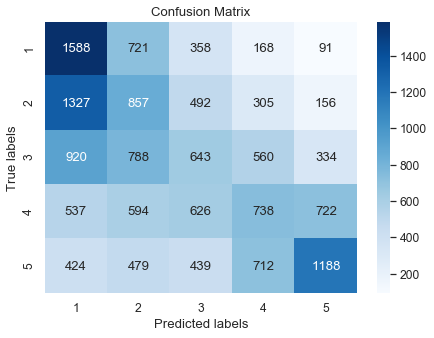

In [ ]:
model2.knn()

In [ ]:
model2a = textblob(df_fiveclass[0:20000])
model2a.train()

[[268 292 101  38  33]
 [181 314 147  79  74]
 [ 74 250 191 150 140]
 [ 27 137 146 196 309]
 [  8 105 100 169 471]]
Accuracy:0.36
F1 Score:0.35511948266327564



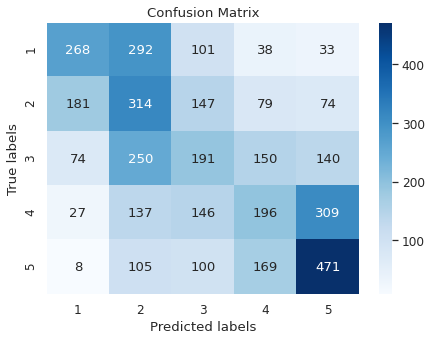

In [ ]:
model2a.svm()

The best performing classifier in this instance was actually Logistic rather than SVM. Unfortunately, it did little better than our best performing VADER model. No matter....

Let's train our Logistic Model on all the data and then export it again for deployment.

In [ ]:
class textblob_deploy():
    def __init__(self, data):
        self.results = []
        self.data = data

    def sentiment_analyzer_scores(self, sentence):
        return TextBlob(sentence).polarity

    def train(self):

        for text in self.data['Comment']:
            self.results.append(self.sentiment_analyzer_scores(text))

        self.results = pd.DataFrame(
    {'Predicted': self.results,
     'Score': self.data['Score']})

    def logistic_regression(self):
        from sklearn.linear_model import LogisticRegression

        regressor = LogisticRegression(multi_class='auto')
        regressor.fit(self.results[['Predicted']], self.results[['Score']])
        return regressor

model2 = textblob_deploy(df_fiveclass)
model2.train()
textblob_model = model2.logistic_regression()

import pickle
pickle.dump(textblob_model, open('textblob.pkl','wb'))

C:\Users\ujjaw\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### Feature-Based Models

Let's do feature based ones now. In this type of model, we use an approach called bag of words (context of the text is not taken into account). Skikit-learns' Count Vectorizer preprocesses, tokenizes, and filters all stopwords and builts a dictionary of features and transforms the text into feature vectors. And then the number of occurrences of each word in a document is divided by the total number of words in the document.

There are a number of classification models we can employ. The ones I think would be particularly effective are Logistic Regression, Naive Bayes, and Support Vector Machine.

All three are covered below with grid search employed on each model.

In [ ]:
class feature():
    def __init__(self, data):

        from sklearn.model_selection import train_test_split

        self.comment = data['Comment']
        self.score = data['Score']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.comment , self.score, test_size=0.2, random_state=0)

    def multiclass(self, classifier = 'SVM'):

        from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
        from sklearn.pipeline import Pipeline
        from sklearn.model_selection import GridSearchCV

        if classifier == 'Logistic':

            from sklearn.linear_model import LogisticRegression

            parameters = {
                'tfidf__use_idf': (True, False),
                'clf__solver': ('newtown-cg', 'sag', 'saga', 'lbfgs'),
                'clf__penalty': ('l1', 'l2', 'elasticnet', 'none'),
                }

            pipeline = Pipeline(
                [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(multi_class='auto')),
                ])

            gs_clf = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

            learner = gs_clf.fit(self.X_train, self.y_train)
            y_test_pred = learner.predict(self.X_test)

            multiclass_eval(y_test_pred, self.y_test)
            cm_plot(y_test_pred, self.y_test, self.score.max() + 1 )
            for param_name in sorted(parameters.keys()):
                print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

        elif classifier == 'NB':

            from sklearn.naive_bayes import MultinomialNB

            parameters = {
                'tfidf__use_idf': (True, False),
                'clf__alpha': (1, 1e-1, 1e-2),
                }

            pipeline = Pipeline(
                [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf = True)),
                ('clf', MultinomialNB()),
                ])

            gs_clf = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

            learner = gs_clf.fit(self.X_train, self.y_train)
            y_test_pred = learner.predict(self.X_test)

            multiclass_eval(y_test_pred, self.y_test)
            cm_plot(y_test_pred, self.y_test, self.score.max() + 1 )
            for param_name in sorted(parameters.keys()):
                print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

        elif classifier == 'comNB':

            from sklearn.naive_bayes import ComplementNB

            parameters = {
                'tfidf__use_idf': (True, False),
                'clf__alpha': (1, 1e-1, 1e-2),
                }

            pipeline = Pipeline(
                [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf = True)),
                ('clf', ComplementNB()),
                ])

            gs_clf = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

            learner = gs_clf.fit(self.X_train, self.y_train)
            y_test_pred = learner.predict(self.X_test)

            multiclass_eval(y_test_pred, self.y_test)
            cm_plot(y_test_pred, self.y_test, self.score.max() + 1 )
            for param_name in sorted(parameters.keys()):
                print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

        elif classifier == 'SGD':

            from sklearn.linear_model import SGDClassifier

            parameters = {
                'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
                'clf__alpha': (0.001, 0.0001, 0.00001, 0.000001),
                'clf__penalty': ('l1', 'l2', 'elasticnet')
                }

            pipeline = Pipeline(
                [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge',
                                      penalty='l1',
                                      random_state=41,
                                     )), #class_weight ={1:1, 0:5}, alpha=0.00001,
                ])

            gs_clf = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

            learner = gs_clf.fit(self.X_train, self.y_train)
            y_test_pred = learner.predict(self.X_test)

            multiclass_eval(y_test_pred, self.y_test)
            cm_plot(y_test_pred, self.y_test, self.score.max() + 1 )
            for param_name in sorted(parameters.keys()):
                print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

        elif classifier == 'SVC':

            from sklearn.svm import SVC

            pipeline = Pipeline(
                [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf = True)),
                ('clf', SVC(C = 1))
                ])

            learner = pipeline.fit(self.X_train, self.y_train)
            y_test_pred = learner.predict(self.X_test)

            multiclass_eval(y_test_pred, self.y_test)
            cm_plot(y_test_pred, self.y_test, self.score.max() + 1 )


In [ ]:
model3 = feature(df_fiveclass)

[[1773  741  234   60   67]
 [ 993 1203  779  170  105]
 [ 353  731 1288  638  250]
 [ 112  250  619 1123 1113]
 [  85   74  195  716 2095]]
Accuracy:0.4745354220840997
F1 Score:0.47152650971360205



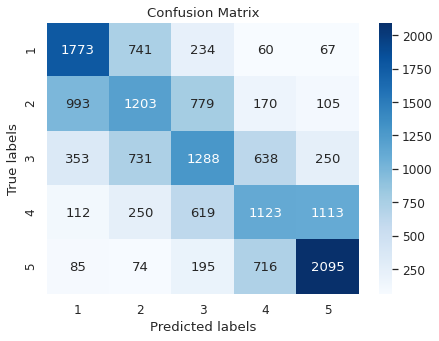

clf__penalty: 'l2'
clf__solver: 'sag'
tfidf__use_idf: False


In [ ]:
model3.multiclass(classifier = 'Logistic')

[[1565  877  289   69   75]
 [ 845 1244  895  196   70]
 [ 301  746 1345  658  210]
 [  81  262  694 1170 1010]
 [  70   91  245  811 1948]]
Accuracy:0.46121646476818673
F1 Score:0.46273153429361996



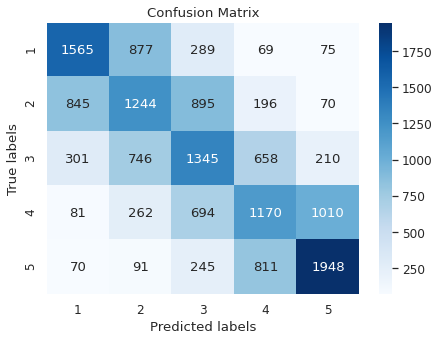

clf__alpha: 0.1
tfidf__use_idf: False


In [ ]:
model3.multiclass(classifier = 'NB')

[[2036  479  208   60   92]
 [1387  869  685  167  142]
 [ 598  595 1149  538  380]
 [ 230  215  569  806 1397]
 [ 154   73  190  459 2289]]
Accuracy:0.4534153611974377
F1 Score:0.4352132998796831



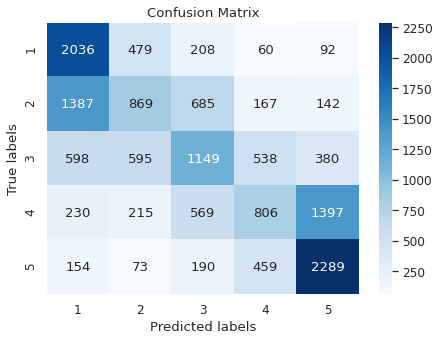

clf__alpha: 1
tfidf__use_idf: False


In [ ]:
model3.multiclass(classifier = 'comNB')

[[1850  673  222   41   89]
 [1065 1120  784  145  136]
 [ 414  703 1283  553  307]
 [ 144  231  654  912 1276]
 [ 103   71  207  579 2205]]
Accuracy:0.46743197818227944
F1 Score:0.45869547237073166



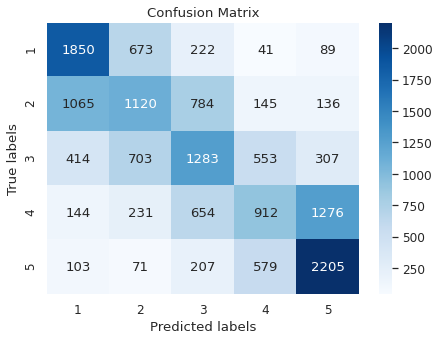

clf__alpha: 0.0001
clf__loss: 'log'
clf__penalty: 'l2'


In [ ]:
model3.multiclass(classifier = 'SGD')

[[197 134  53  13  10]
 [ 95 181  99  20  19]
 [ 30 116 155  72  37]
 [ 14  37  84 121 125]
 [  5  14  32  95 242]]
Accuracy:0.448
F1 Score:0.44743179977595765



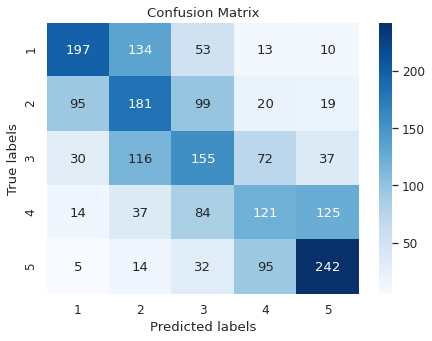

In [ ]:
model3a = feature(df_fiveclass[0:10000])
model3a.multiclass(classifier = 'SVC')

In [ ]:
class feature1():
    def __init__(self, data):

        self.comment = data['Comment']
        self.score = data['Score']

    def multiclass(self, classifier):

        from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
        from sklearn.pipeline import Pipeline

        if classifier == 'Logistic':

            from sklearn.linear_model import LogisticRegression

            pipeline = Pipeline(
                [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf = False)),
                ('clf', LogisticRegression(multi_class='auto',
                                          penalty = 'l2',
                                          solver = 'sag')),
                ])

            learner = pipeline.fit(self.comment, self.score)
            return learner

        elif classifier == 'SVC':

            from sklearn.svm import SVC

            pipeline = Pipeline(
                [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf = False)),
                ('clf', SVC(C=1)),
                ])

            learner = pipeline.fit(self.comment, self.score)
            return learner

        elif classifier == 'SGD':

            from sklearn.linear_model import SGDClassifier

            pipeline = Pipeline(
                [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(alpha= 0.0001,
                                      loss= 'log' ,
                                      penalty= 'l2'
                                     )),
                ])

            learner = pipline.fit(self.comment, self.score)
            return learner

        elif classifier == 'NB':

            from sklearn.naive_bayes import MultinomialNB

            pipeline = Pipeline(
                [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf = False)),
                ('clf', MultinomialNB(alpha = 0.1)),
                ])


            learner = pipeline.fit(self.comment, self.score)
            return learner

        elif classifier == 'xgboost':
            from xgboost import XGBClassifier

            parameters = {
                'tfidf__use_idf': (True, False),
                }

            pipeline = Pipeline(
                [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier()),
                ])

            gs_clf = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

            learner = gs_clf.fit(self.X_train, self.y_train)
            y_test_pred = learner.predict(self.X_test)

            multiclass_eval(y_test_pred, self.y_test)
            cm_plot_2(y_test_pred, self.y_test, self.score.max() + 1 )
            for param_name in sorted(parameters.keys()):
                print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))


Pipeline(steps=[('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', LogisticRegression(solver='sag'))])

In [ ]:
model4 = feature1(df_fiveclass)
Logistic = model4.multiclass(classifier = 'Logistic')
NB = model4.multiclass(classifier = 'NB')

model3 = feature1(df_fiveclass[0:20000])
SVC = model4.multiclass(classifier = 'SVC')

In [ ]:
import pickle

In [ ]:
pickle.dump(SVC, open('SVC.pkl','wb'))

In [ ]:
pickle.dump(Logistic, open('Logistic.pkl','wb'))
pickle.dump(NB, open('NB.pkl','wb'))

### Word Embeddings

Let's explore embeddings-based methods now!
<br><br>

Word embeddings are a way of mapping words to vectors and words with similar meaning end up having a similar representation. Each word is mapped to a real-valued vector in a predefined vector space. Compared with feature-based representation where there may be thousands or millions of dimensions in a sparse-matrix format, word embeddings are often in the hundreds or thousands range. In this format, deep learning architectures can be utilized much more effectively.

If you would like to learn more, I would suggest checking out this article.

*https://towardsdatascience.com/what-the-heck-is-word-embedding-b30f67f01c81*


In [ ]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()
en_stop = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(document):
        document = re.sub(r'\W', ' ', str(document))
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        document = re.sub(r'^b\s+', '', document)
        document = document.lower()
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]
        preprocessed_text = ' '.join(tokens)
        print('Completed Preprocessing')
        return preprocessed_text

In [ ]:
df_fiveclass['Clean Comment'] = [preprocess_text(sentence) for sentence in df_fiveclass['Comment'] if sentence.strip() !='']

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Preprocessing
Completed Prepro

In [ ]:
df_fiveclass[['Clean Comment', 'Score']].to_csv('C:/Users/ujjaw/OneDrive/Documents/df_fiveclass_clean.csv')

#### FastText

This model was developed by Facebook's AI Research Lab in 2015 and is a popular library used for text classification. They provide 3 different models with 300 dimensions each.

The primary differentiator between FastText from other libraries before it like word2vec or glove is that it makes use of character level representations.
Each word is represented as bag of characters n-grams in addition to the word itself. For example, sunny is composed of [sun, sunn,sunny],[sunny,unny,nny]  etc, where n could range from 1 to the length of the word.  

In addition, it is extremely lightweight and can even be implemented on mobile devices.

Please see https://fasttext.cc/docs/en/supervised-tutorial.html for more information

In [ ]:
# Clean your data

import io
from io import StringIO
import csv

df_fiveclass = pd.read_csv('https://raw.githubusercontent.com/ujjawalmadan/Rate-My-Professors/master/df_fiveclass.csv?token=AMOAHYMMOF65VFLKDTEEVGC7CNJG4')
df_fiveclass['Score'] = ['__label__' + str(i) for i in df_fiveclass['Score']]
df_fiveclass['Comment'] = df_fiveclass['Comment'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)
df_fiveclass = df_fiveclass[['Score', 'Comment']]

df_fiveclass_clean = pd.read_csv('https://raw.githubusercontent.com/ujjawalmadan/Rate-My-Professors/master/df_fiveclass_clean.csv?token=AMOAHYJRER6SWRPHHBVC7KK7CNJKW')
df_fiveclass_clean['Score'] = ['__label__' + str(i) for i in df_fiveclass_clean['Score']]
df_fiveclass_clean['Comment'] = df_fiveclass_clean['Clean Comment'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)
df_fiveclass_clean = df_fiveclass_clean[['Score', 'Comment']]

In [ ]:
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip v0.9.2.zip

--2020-07-27 18:24:44--  https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2 [following]
--2020-07-27 18:24:44--  https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.2.zip’

v0.9.2.zip              [   <=>              ]   4.17M  6.18MB/s    in 0.7s    

2020-07-27 18:24:45 (6.18 MB/s) - ‘v0.9.2.zip’ saved [4369852]

Archive:  v0.9.2.zip
5b5943c118b0ec5fb9cd8d20587de2b2d3966dfe
   creating: fastText-0.9.2/
   creating: fastText-0.9.2/.circleci/
  inflating: fastText

In [ ]:
cd fastText-0.9.2

/content/fastText-0.9.2


In [ ]:
!make

c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/autotune.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/vector.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/model.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/utils.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -

In [ ]:
pip install .

Processing /content/fastText-0.9.2
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3015766 sha256=e1592d95fa2aa103f258daa5f4dd7db7ad992711a1083ab2db34ed710b804704
  Stored in directory: /root/.cache/pip/wheels/1a/f3/f7/6e23c787ef7a44142867cdb80e5718cbbeb69e379e8e60e380
Successfully built fasttext


In [ ]:
!./fasttext

usage: fasttext <command> <args>

The commands supported by fasttext are:

  supervised              train a supervised classifier
  quantize                quantize a model to reduce the memory usage
  test                    evaluate a supervised classifier
  test-label              print labels with precision and recall scores
  predict                 predict most likely labels
  predict-prob            predict most likely labels with probabilities
  skipgram                train a skipgram model
  cbow                    train a cbow model
  print-word-vectors      print word vectors given a trained model
  print-sentence-vectors  print sentence vectors given a trained model
  print-ngrams            print ngrams given a trained model and word
  nn                      query for nearest neighbors
  analogies               query for analogies
  dump                    dump arguments,dictionary,input/output vectors



In [ ]:
import os
os.chdir("/content")
!ls

fastText-0.9.2	sample_data  v0.9.2.zip


In [ ]:
# Upload your data

df_fiveclass[['Score', 'Comment']].to_csv(r'/content/df_fiveclass.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
df_fiveclass_clean[['Score', 'Comment']].to_csv(r'/content/df_fiveclass_clean.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [ ]:
# Shapes so you can specify rows

print(0.8*df_fiveclass.shape[0])
print(0.2*df_fiveclass.shape[0])

63067.200000000004
15766.800000000001


In [ ]:
# Splitting into training and testing

!head -n 63067 "/content/df_fiveclass.txt" > "/content/df_fiveclass_train.txt"
!tail -n 15767 "/content/df_fiveclass.txt" > "/content/df_fiveclass_test.txt"
!head -n 63067 "/content/df_fiveclass_clean.txt" > "/content/df_fiveclass_clean_train.txt"
!tail -n 15767 "/content/df_fiveclass_clean.txt" > "/content/df_fiveclass_clean_test.txt"

In [ ]:
# Clean versions of train and test sets

!cat "/content/df_fiveclass_train.txt" | sed -e "s/\([.\!?,’/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > "/content/df_fiveclass_train_clean.txt"
!cat "/content/df_fiveclass_test.txt" | sed -e "s/\([.\!?,’/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > "/content/df_fiveclass_test_clean.txt"

In [ ]:
cd fastText-0.9.2

/content/fastText-0.9.2


In [ ]:
# Autotune - Multiclass

!./fasttext supervised -input "/content/df_fiveclass_train_clean.txt" -output fiveclass_2 -autotune-validation "/content/df_fiveclass_test_clean.txt" -autotune-duration 3000 -autotune-modelsize 2M
!./fasttext test fiveclass_2.ftz "/content/df_fiveclass_test_clean.txt"

Progress:  33.7% Trials:   10 Best score:  0.482654 ETA:   0h33m 9stcmalloc: large alloc 1785233408 bytes == 0x55be17a84000 @  0x7f4de94f6887 0x55bddb50f1dd 0x55bddb51e2de 0x55bddb52621a 0x55bddb4f037f 0x55bddb52d7eb 0x55bddb4e1887 0x7f4de8593b97 0x55bddb4e1b4a
Progress:  50.5% Trials:   14 Best score:  0.483288 ETA:   0h24m46stcmalloc: large alloc 2140667904 bytes == 0x55be17a80000 @  0x7f4de94f6887 0x55bddb50f1dd 0x55bddb51e2de 0x55bddb52621a 0x55bddb4f037f 0x55bddb52d7eb 0x55bddb4e1887 0x7f4de8593b97 0x55bddb4e1b4a
Progress:  65.4% Trials:   20 Best score:  0.488045 ETA:   0h17m16stcmalloc: large alloc 4546428928 bytes == 0x55be17a80000 @  0x7f4de94f6887 0x55bddb50f1dd 0x55bddb51e2de 0x55bddb52621a 0x55bddb4f037f 0x55bddb52d7eb 0x55bddb4e1887 0x7f4de8593b97 0x55bddb4e1b4a
Progress: 100.0% Trials:   24 Best score:  0.488045 ETA:   0h 0m 0s
Training again with best arguments
Read 2M words
Number of words:  36881
Number of labels: 5
Progress: 100.0% words/sec/thread:   50972 lr:  0.000

In [ ]:
# Autotune - Multiclass (clean)

!./fasttext supervised -input "/content/df_fiveclass_clean_train.txt" -output fiveclass_3 -autotune-validation "/content/df_fiveclass_clean_test.txt" -autotune-duration 180 -autotune-modelsize 2M
!./fasttext test fiveclass_3.ftz "/content/df_fiveclass_clean_test.txt"

In [ ]:
import fasttext

In [ ]:
model = fasttext.load_model("/content/fastText-0.9.2/fiveclass_2.ftz")

In [ ]:
model.predict('This school is old and grey. Do not go here. But the professors are decent.')

(('__label__1',), array([0.65536773]))

In [ ]:
model.test("/content/df_fiveclass_test_clean.txt")

(15767, 0.4847466226929663, 0.4847466226929663)

#### BERT

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper that was published by Google AI Language in 2018. In addition to text classification, it performs very well on a wide variety of NLP tasks such as Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), Next Sentence Prediction and others.

The key differentiator between BERT and frameworks prior to it is that it is bidirectionally trained on the text. Rather than a left to right approach or even a combined left to right and right to left where the model reads the input as a sequence of words, this bidirectionality, which has been enabled by the introduction of Transformers, was previously impossible. Ultimately, this allows the model to learn the context of a word based on all its surroundings (left and right of the word). Transformers, which were introduced in 2017 by Google, can process data in any order which allows them to train on larger amounts of data than was previously possible.

Furthermore, BERT has been designed to be pre-trained, so that we as practitioners only need to fine-tune it on the training set.



In [ ]:
!pip install ktrain

     |████████████████████████████████| 25.2MB 121kB/s 
     |████████████████████████████████| 421.8MB 30kB/s 
     |████████████████████████████████| 6.7MB 53.2MB/s 
     |████████████████████████████████| 983kB 8.7MB/s 
     |████████████████████████████████| 245kB 55.4MB/s 
     |████████████████████████████████| 778kB 50.3MB/s 
     |████████████████████████████████| 471kB 49.2MB/s 
     |████████████████████████████████| 3.9MB 18.4MB/s 
     |████████████████████████████████| 450kB 47.7MB/s 
     |████████████████████████████████| 3.0MB 42.3MB/s 
     |████████████████████████████████| 890kB 49.8MB/s 
     |████████████████████████████████| 1.1MB 42.0MB/s 
  Created wheel for ktrain: filename=ktrain-0.18.5-cp36-none-any.whl size=25253441 sha256=de81aa3c1d8c9f9f2e0d8286e2c674e6bc8820bb7d23e1b07e6f4b5426e5ff9a
  Stored in directory: /root/.cache/pip/wheels/29/33/cd/2a24a3b6344bb291ede07a903985664bf747b3ea50d9c05ce4
  Created wheel for keras-bert: filename=keras_bert-0.85.0-cp36-non

In [ ]:
import ktrain
from ktrain import text
import tensorflow as tf

In [ ]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=df_fiveclass,
                                                                   text_column = 'Comment',
                                                                   label_columns = 'Score',
                                                                   maxlen = 130,
                                                                   preprocess_mode = 'bert')

# (train, val, preproc) = text.texts_from_df(train_df = df,
#                                            text_column = 'Comment',
#                                            label_columns = [1,2,3,4,5],
#                                            #val_df = data_test,
#                                            maxlen = 100,
#                                            preprocess_mode = 'distilbert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model = text.text_classifier(name = 'bert', train_data = (X_train, y_train), preproc = preproc)

# model = text.text_classifier(name = 'distilbert', train_data = train, preproc=preproc)

Is Multi-Label? False
maxlen is 130
done.


In [ ]:
learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data = (X_test, y_test),
                             batch_size = 24)

# learner = ktrain.get_learner(model = model,
#                              train_data = train,
#                              val_data = val,
#                              batch_size = 24)

In [ ]:
learner.autofit(5e-7)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-07...
Train on 70950 samples, validate on 7884 samples
Epoch 1/1024
70950/70950 [==============================] - 1874s 26ms/sample - loss: 1.5494 - accuracy: 0.3141 - val_loss: 1.2525 - val_accuracy: 0.4466
Epoch 2/1024
70950/70950 [==============================] - 1877s 26ms/sample - loss: 1.2105 - accuracy: 0.4580 - val_loss: 1.1406 - val_accuracy: 0.4934
Epoch 3/1024
70950/70950 [==============================] - 1873s 26ms/sample - loss: 1.1497 - accuracy: 0.4821 - val_loss: 1.1126 - val_accuracy: 0.5048
Epoch 4/1024
70950/70950 [==============================] - 1839s 26ms/sample - loss: 1.1209 - accuracy: 0.4932 - val_loss: 1.0951 - val_accuracy: 0.5094
Epoch 5/1024
70950/70950 [==============================] - 1837s 26ms/sample - loss: 1.1026 - accuracy: 0.4999 - val_loss: 1.0842 - val_accuracy: 0.51

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
data = ['this school really sucks. Do not go here!']

In [ ]:
predictor.predict(data)

['2']

In [ ]:
predictor.get_classes()

['1', '2', '3', '4', '5']

In [ ]:
predictor.save('/content/bert')

In [ ]:
learner.validate(val_data=(X_test, y_test), class_names=predictor.get_classes())

              precision    recall  f1-score   support

           1       0.62      0.65      0.63      1504
           2       0.41      0.43      0.42      1476
           3       0.49      0.43      0.46      1667
           4       0.46      0.38      0.41      1598
           5       0.62      0.74      0.67      1639

    accuracy                           0.53      7884
   macro avg       0.52      0.53      0.52      7884
weighted avg       0.52      0.53      0.52      7884



array([[ 985,  404,   78,   12,   25],
       [ 455,  628,  318,   57,   18],
       [ 130,  404,  719,  312,  102],
       [  19,   69,  295,  601,  614],
       [  11,   13,   72,  325, 1218]])

#### ELMO

ELMO (Embeddings from Language Models), developed in 2018 by AllenNLP uses a deep, bi-directional LSTM model to create word representations. Similar to fasttext, it is also character based allowing the model to form representations of out-of-vocabulary words unseen in training.

However, traditional word embeddings such as word2vec, GloVe and even fasttext fall short in recognizing the context of a sentence. This is because they only have one representation per words, and so cannot capture the meaning of the word given the context.

For example:

* He kicked the **bucket**.
* I have yet to cross-off all the items on my **bucket** list.
* The **bucket** was filled with water.

*Bucket* in each of these example sentences have a different meaning. ELMo would not only be able to recognize the context of bucket in each of those sentences, if trained on enough data it would be able to pick up on language patterns and predict the next word in a sentence. It is able to not only understand the next word, but also the previous word because of its bidirectional architecture. The ELMo vector is only assigned to a token or word after the entire context of the sentence is taken into account.



![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/output_YyJc8E.gif)

In [ ]:
import spacy
from tqdm import tqdm
import re
import time
import pickle
import tensorflow_hub as hub
import tensorflow as tf

In [ ]:
pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5MB 39kB/s 
     |████████████████████████████████| 512kB 41.2MB/s 
     |████████████████████████████████| 3.8MB 41.7MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=c74fdf210dc56544c9029b0f29845d46d62b79d420db4d651ceaeb789e0ce8bc
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing i

In [ ]:
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable = True)

In [ ]:
x = ["Roasted ants are a popular snack in Columbia"]
embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
embeddings.shape

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


TensorShape([Dimension(1), Dimension(8), Dimension(1024)])

In [ ]:
def elmo_vectors(x):
  embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(embeddings,1))

In [ ]:
train = df_fiveclass

In [ ]:
list_train = [train[i:i+100] for i in range(0,train.shape[0],100)]

In [ ]:
elmo_train = [elmo_vectors(x['Comment']) for x in list_train]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
elmo_train_new = np.concatenate(elmo_train, axis = 0)

In [ ]:
pickle_out = open("elmo_train_03032019.pickle","wb")
pickle.dump(elmo_train_new, pickle_out)
pickle_out.close()


In [ ]:
# load elmo_train_new
pickle_in = open("elmo_train_03032019.pickle", "rb")
elmo_train_new = pickle.load(pickle_in)

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xvalid, ytrain, yvalid = train_test_split(elmo_train_new,
                                                  train['Score'],
                                                  random_state=42,
                                                  test_size=0.2)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lreg = LogisticRegression()
lreg.fit(xtrain, ytrain)

In [ ]:
preds_valid = lreg.predict(xvalid)
multiclass_eval(preds_valid, yvalid)

#### Flair

Flair, created by Zalando Reserach, is a state-of-the-art deep learning sequence tagging NLP library built directly on PyTorch. Zooland Research has released several already pre-trained models including one for sentiment analysis/text classification.

Once again, context is taken into account with Flair. At the heart of Flair is contextual String Embeddings. Rather than just being able to predict the next/previous word as in ELMo, it can predict the next/ previous character as well. Sentences are broken down into character sequences and embeddings are learned at the character level.

In addition, it is unique in that that it allows one to stack different kinds of word embeddings. For example, one could combine GloVE, BERT, ELMo, etc. This provides the model with added word-level context.


![alt text](https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2018/09/image1.png)

*'Illustration of our approach. A sentence (bottom) is input as a character sequence into a pre-trained bidirectional character language model (LM, yellow in Figure). From this LM, we retrieve for each word a contextual embedding by extracting the first and last character cell states. This word embedding is then passed into a vanilla BiLSTM-CRF sequence labeler (blue in Figure), achieving robust state-of-the-art results on downstream tasks (NER in this example).'* - Zalando Research

Unfortunately, I had a bit of difficulty implementing Flair in this notebook because of some issues with the prexisting packages. I created a new notebook where I train the Flair model. Please see this Flair-specific Notebook - https://colab.research.google.com/drive/1LprsBWZiq2fphZaWNjZHQKqwgA7qzyG4?usp=sharing

## Evaluating Results

In [ ]:
plt.figure(figsize=(17,10))

N = 11
blue_bar = pd.Series([0.379, 0.364, 0.4745, 0.461, 0.453, 0.467, 0.448, 0.488, 0.5283, 0.5, 0.5017])
orange_bar = pd.Series([0.374, 0.36, 0.4715, 0.463, 0.435, 0.459, 0.447, 0.4847, 0.518, 0.5, 0.5])
ind = np.arange(N)

width = 0.4
plt.bar(ind, blue_bar , width, label='Accuracy')
plt.bar(ind + width, orange_bar, width, label='F1 Score')

plt.xlabel('Models')
plt.title('Results')
plt.xticks(ind + width / 2, ['VADER', 'TextBlob', 'Logistic', 'Multinomial NB', 'Complement NB', 'SGD', 'SVC', 'FastText', 'BERT', 'ELMo', 'Flair'])

plt.legend(loc='best')
plt.show()

NameError: ignored

As we can see clearly, Flair is our best performing model both in terms of ...

##### Notes for Improvement
